<a href="https://colab.research.google.com/github/microhum/Evaporation-Forecasting/blob/main/Evaporation_forcasting_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)


In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['axes.grid'] = False

In [ ]:
def mae(y_true, predictions):
  y_true, predictions = np.array(y_true), np.array(predictions)
  return np.mean(np.abs(y_true - predictions))

def rmse(y_true, predictions):
  y_true, predictions = np.array(y_true), np.array(predictions)
  mse = np.mean(np.power(y_true - predictions, 2))
  return np.sqrt(mse)

def mape(y_true, predictions):
  y_true, predictions = np.array(y_true), np.array(predictions)
  return np.mean(np.abs((y_true - predictions) / y_true)) * 100

In [ ]:
# load the data
df = pd.read_csv('WaterDataset_22Y.csv')
df = df.iloc[:,:5]
df = df.dropna()
df

,Date,Evaporation,MinTemp,MaxTemp,WindSpeed
0,1/1/2001,2.75,16.0,28.9,15.58
1,1/2/2001,2.42,18.5,29.0,13.25
2,1/3/2001,2.42,13.5,29.2,19.66
3,1/4/2001,2.62,13.6,29.7,17.65
4,1/5/2001,2.26,13.5,29.5,18.05
...,...,...,...,...,...
8030,12/27/2022,2.50,16.8,30.1,10.70
8031,12/28/2022,2.28,17.0,30.0,8.49
8032,12/29/2022,2.77,17.1,29.5,8.31
8033,12/30/2022,2.44,18.1,30.0,8.13


In [ ]:
df.isna().sum()

Date           0
Evaporation    0
MinTemp        0
MaxTemp        0
WindSpeed      0
dtype: int64

In [ ]:
df = df.iloc[:-365,:]

In [ ]:
#x = df['Evaporation'].fillna(method='ffill')
x = df.iloc[:,1:].values

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

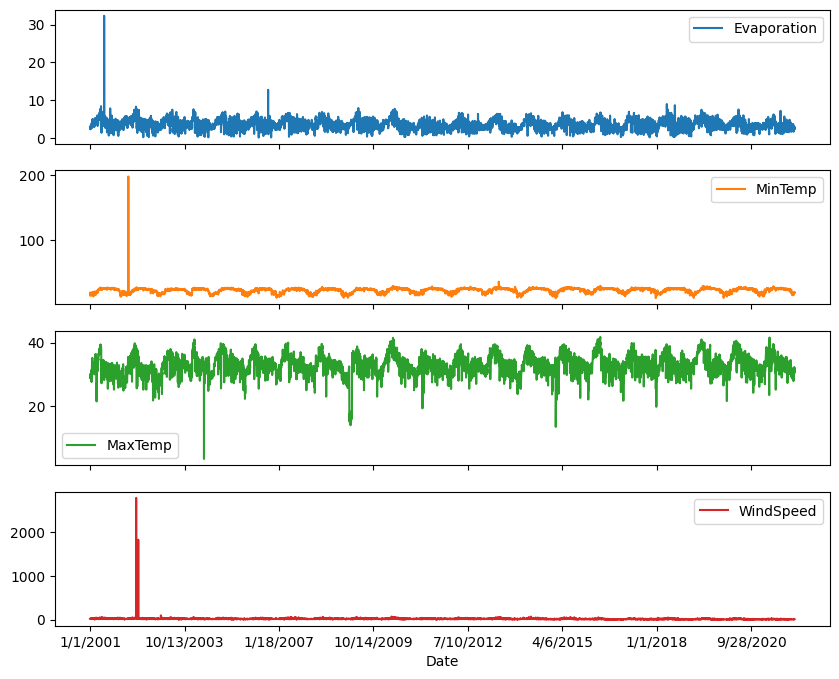

In [ ]:
df.set_index('Date')[['Evaporation', 'MinTemp','MaxTemp', 'WindSpeed']].plot(subplots=True)

In [ ]:
x[1:5]

array([[ 2.42, 18.5 , 29.  , 13.25],
       [ 2.42, 13.5 , 29.2 , 19.66],
       [ 2.62, 13.6 , 29.7 , 17.65],
       [ 2.26, 13.5 , 29.5 , 18.05]])

In [ ]:
y = pd.DataFrame(x).iloc[:,:1].to_numpy()

In [ ]:
# scale the data
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler = X_scaler.fit(x)
x = X_scaler.transform(x)

In [ ]:
# scale the data
Y_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = Y_scaler.fit(y)
y = Y_scaler.transform(y)

In [ ]:
# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 365  # length of output sequences (forecast period)

X = []
Y = []

X_valid = []
Y_valid = []

for i in range(n_lookback, len(x) - n_forecast + 1):
    X.append(x[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

for i in range(n_lookback, len(x)-1000 - n_forecast + 1):
    X_valid.append(x[:-1000][i - n_lookback: i])
    Y_valid.append(y[:-1000][i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [ ]:
N = 100
model = Sequential([
                    layers.LSTM(N,return_sequences=True, input_shape= (n_lookback, 4)),
                    layers.LSTM(N,return_sequences=False),
#                     layers.Dropout(0.2),

                    # Add the output layer
                    layers.Dense(n_forecast)])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 365, 100)          42000     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 365)               36865     
                                                                 
Total params: 159,265
Trainable params: 159,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X.shape, Y.shape, X_valid.shape, Y_valid.shape

((6731, 365, 4), (6731, 365, 1), (5731, 365, 4), (5731, 365, 1))

In [ ]:
early_stopping = EarlyStopping(monitor='loss',mode='min',patience=40)
mc = ModelCheckpoint('LSTM_best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)
optimizer = Adam(learning_rate=3e-4)

### Fit model

In [ ]:
model.compile(loss='mean_squared_error', optimizer=optimizer ,metrics=['mean_absolute_error'])
History = model.fit(X, Y, epochs=200, batch_size=128, callbacks=[mc,early_stopping],validation_data=(X_valid,Y_valid))


Epoch 1/200
53/53 [==============================] - 7s 70ms/step - loss: 0.0060 - mean_absolute_error: 0.0621 - val_loss: 0.0017 - val_mean_absolute_error: 0.0332
Epoch 2/200
53/53 [==============================] - 3s 56ms/step - loss: 0.0016 - mean_absolute_error: 0.0322 - val_loss: 0.0016 - val_mean_absolute_error: 0.0322
Epoch 3/200
53/53 [==============================] - 3s 55ms/step - loss: 0.0016 - mean_absolute_error: 0.0319 - val_loss: 0.0016 - val_mean_absolute_error: 0.0320
Epoch 4/200
53/53 [==============================] - 3s 54ms/step - loss: 0.0016 - mean_absolute_error: 0.0318 - val_loss: 0.0016 - val_mean_absolute_error: 0.0319
Epoch 5/200
53/53 [==============================] - 3s 55ms/step - loss: 0.0016 - mean_absolute_error: 0.0317 - val_loss: 0.0016 - val_mean_absolute_error: 0.0318
Epoch 6/200
53/53 [==============================] - 3s 56ms/step - loss: 0.0016 - mean_absolute_error: 0.0316 - val_loss: 0.0016 - val_mean_absolute_error: 0.0317
Epoch 7/200
53/5

train eval
211/211 [==============================] - 2s 11ms/step - loss: 0.0010 - mean_absolute_error: 0.0245
validation eval
180/180 [==============================] - 2s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0247


[0.00104118837043643, 0.024712257087230682]

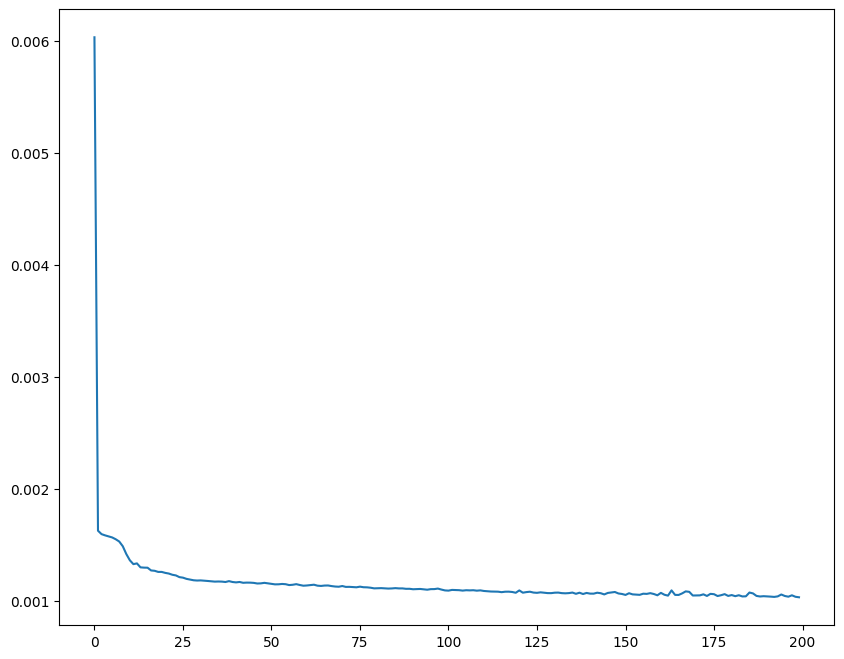

In [ ]:
plt.plot(History.history['loss'])
print('train eval')
model.evaluate(X,Y)
print('validation eval')
model.evaluate(X_valid,Y_valid)

In [ ]:
# generate the forecasts
X_ = x[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 4)

Y_ = model.predict(X_).reshape(-1,1)
Y_ = Y_scaler.inverse_transform(Y_)



1/1 [==============================] - 1s 623ms/step


In [ ]:
Y_.shape

(365, 1)

In [ ]:
test_df = pd.read_csv('WaterDataset_22Y.csv')
test_df = test_df.iloc[-365:,:2]
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df.set_index('Date')
test_df.shape

(365, 1)

In [ ]:
test_df

,Evaporation
Date,
2022-01-01,2.82
2022-01-02,2.58
2022-01-03,2.77
2022-01-04,2.62
2022-01-05,2.66
...,...
2022-12-27,2.50
2022-12-28,2.28
2022-12-29,2.77


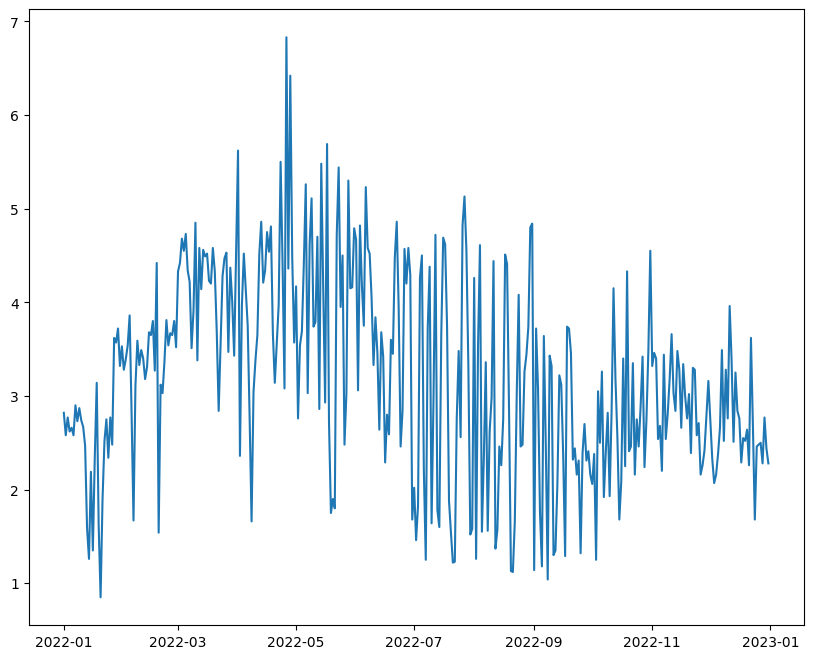

In [ ]:
plt.plot(test_df['Evaporation'])

<ipython-input-102-fb5cd09ba66c>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[1000:].append(df_future).set_index('Date')


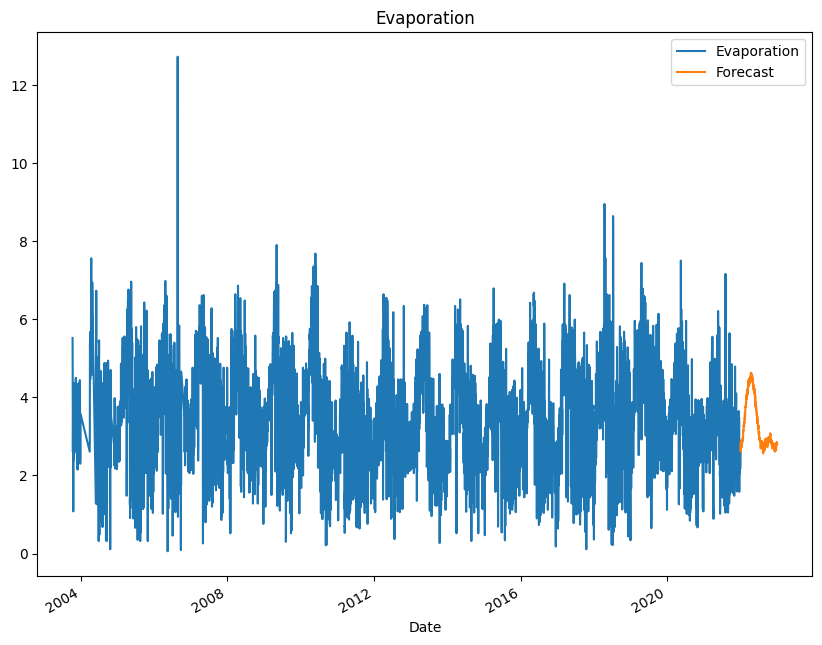

<ipython-input-102-fb5cd09ba66c>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


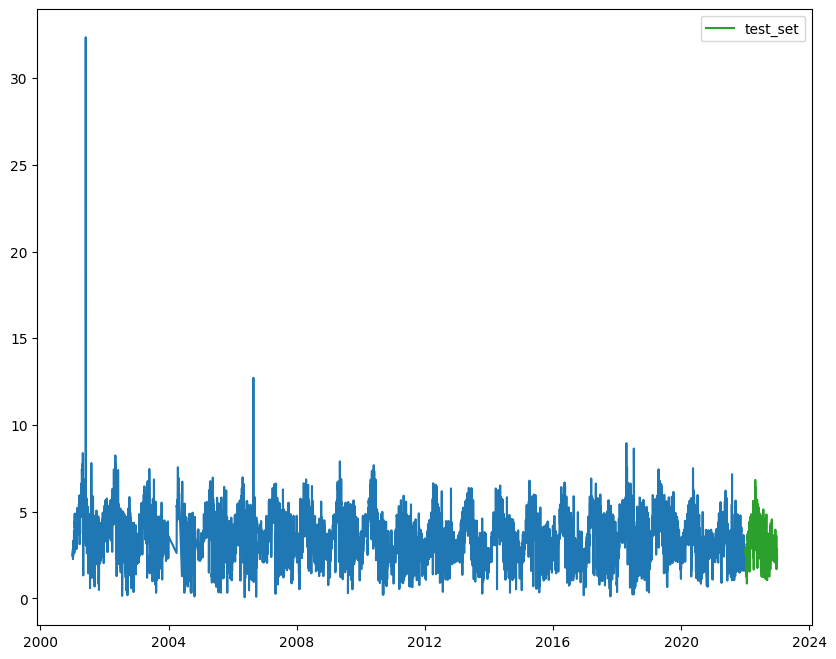

<ipython-input-102-fb5cd09ba66c>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[-100:].append(df_future).set_index('Date')


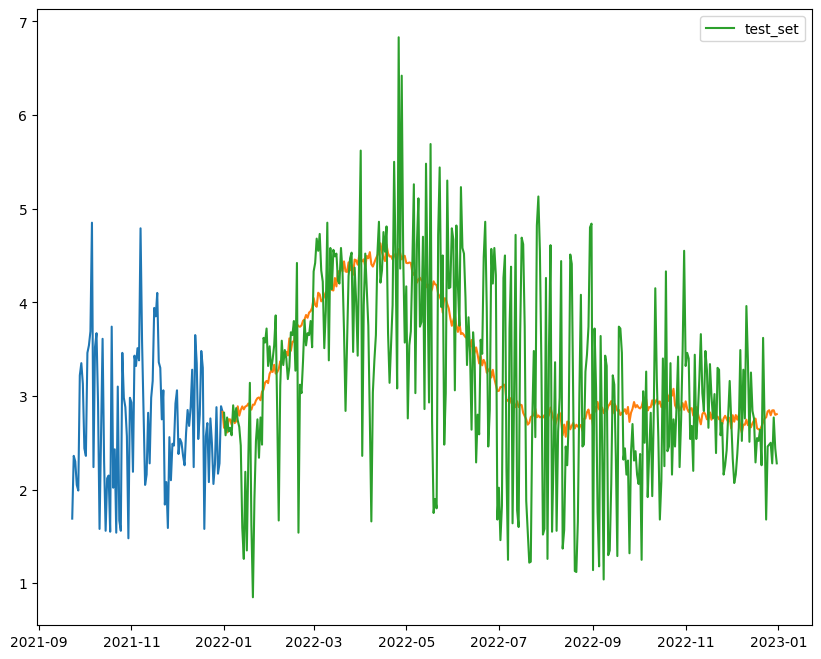

In [ ]:
def showResult():
  # organize the results in a data frame
  df_past = df.iloc[:,:2]
  df_past['Date'] = pd.to_datetime(df_past['Date'])
  df_past['Forecast'] = np.nan
  df_past['Forecast'].iloc[-1] = df_past['Evaporation'].iloc[-1]

  df_future = pd.DataFrame(columns=['Evaporation'])
  df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
  df_future['Forecast'] = Y_.flatten()
  df_future['Evaporation'] = np.nan

  results = df_past[1000:].append(df_future).set_index('Date')

  # plot the results
  results.plot(title='Evaporation')
  plt.show()

  results = df_past.append(df_future).set_index('Date')
  plt.plot(results)
  plt.plot(test_df,label = 'test_set')
  plt.legend()
  plt.show()

  results = df_past[-100:].append(df_future).set_index('Date')
  plt.plot(results)
  plt.plot(test_df,label = 'test_set')
  plt.legend()
  plt.show()

showResult()

In [ ]:
print('MAE',mae(test_df,Y_))
print('MAPE',mape(test_df,Y_))
print('RMSE',rmse(test_df,Y_))

MAE 0.6959766364424197
MAPE 27.89964687544128
RMSE 0.9008964072665633


In [ ]:
print(f'{sum(Y_.flatten())}')
print(f'{sum(test_df["Evaporation"])}')

1207.486198425293
1168.7800000000007


## CNN-LSTM

In [ ]:
x = x[:-161]
y = y[:-161]

In [ ]:
x.shape, y.shape

((7299, 4), (7299, 1))

In [ ]:
lstm_cnn_model = Sequential([
    layers.TimeDistributed(layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape= (None,n_lookback, 4) ),
    layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)),
    layers.TimeDistributed(layers.Flatten()),
    layers.LSTM(50, activation='relu'),
    layers.Dense(n_forecast)
])



In [ ]:
# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 365  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [ ]:
early_stopping = EarlyStopping(monitor='loss',mode='min',patience=40)
mc = ModelCheckpoint('CNN_LSTM_best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)
optimizer = Adam(learning_rate=3e-4)

In [ ]:
lstm_cnn_model.compile(loss='mean_squared_error', optimizer=optimizer ,metrics=['mean_absolute_error'])

In [ ]:
X.shape[0]%365

0

In [ ]:
X.shape[0]//365

18

In [ ]:
X.shape

(6570, 365, 1)

In [ ]:
X = X.reshape((X.shape[0], 1, 365, 4))

ValueError: ignored

In [ ]:
History = lstm_cnn_model.fit(X, Y, epochs=200, batch_size=32, callbacks=[mc,early_stopping])

ValueError: ignored

4/4 [==============================] - 0s 5ms/step - loss: 0.0165 - mean_absolute_error: 0.1008


[0.016498763114213943, 0.10079161822795868]

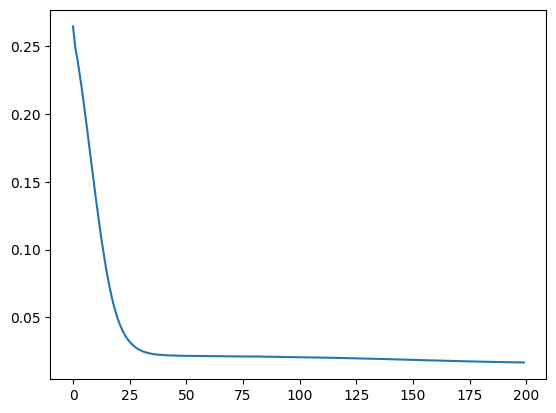

In [ ]:
plt.plot(History.history['loss'])
lstm_cnn_model.evaluate(X,Y)

In [ ]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape((1, 1, 600, 1))
Y_ = lstm_cnn_model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)



1/1 [==============================] - 0s 212ms/step


<ipython-input-203-34dd4c117c14>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[1000:].append(df_future).set_index('Date')


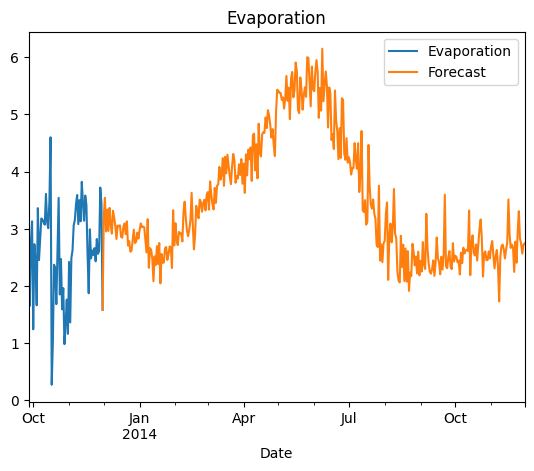

<ipython-input-203-34dd4c117c14>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


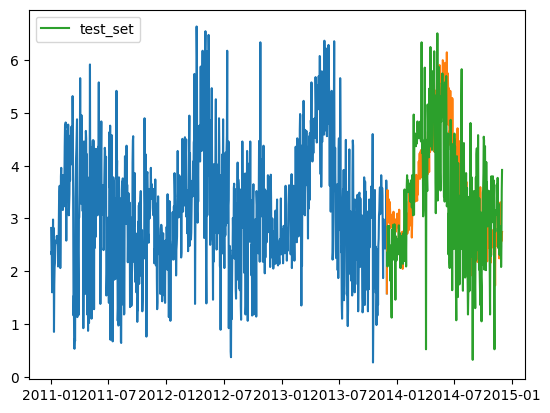

<ipython-input-203-34dd4c117c14>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[2000:].append(df_future).set_index('Date')


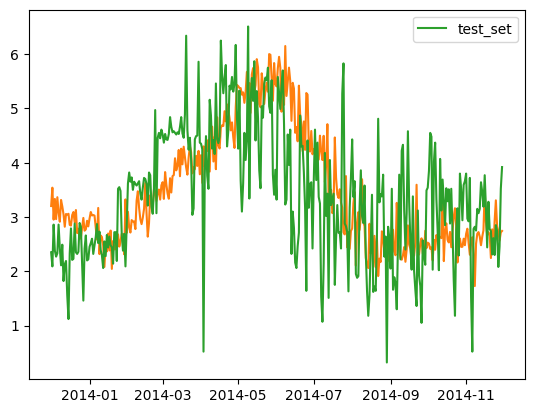

In [ ]:
showResult()

In [ ]:
print('MAE',mae(test_df,Y_))
print('MAPE',mape(test_df,Y_))
print('RMSE',rmse(test_df,Y_))

MAE 0.8175666187234122
MAPE 32.45456514853093
RMSE 1.0537983682022414


# ConvLSTM

In [ ]:
ConvLSTM_model = Sequential([
    layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, n_lookback, 4)),
    layers.Flatten(),
    layers.Dense(n_forecast)
])


In [ ]:
early_stopping = EarlyStopping(monitor='loss',mode='min',patience=40)
mc = ModelCheckpoint('CONVLSTM_best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)
optimizer = Adam(learning_rate=3e-4)

In [ ]:
# generate the input and output sequences
n_lookback = 365  # length of input sequences (lookback period)
n_forecast = 365  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [ ]:
ConvLSTM_model.compile(loss='mean_squared_error', optimizer=optimizer ,metrics=['mean_absolute_error'])

In [ ]:
X = X.reshape((X.shape[0], 1, 1, 365, 4))

ValueError: ignored

In [ ]:
X.shape

In [ ]:
History = ConvLSTM_model.fit(X, Y, epochs=200, batch_size=32, callbacks=[mc,early_stopping])

ValueError: ignored

4/4 [==============================] - 0s 9ms/step - loss: 2.5150e-06 - mean_absolute_error: 0.0011


[2.5150472993118456e-06, 0.0010581797687336802]

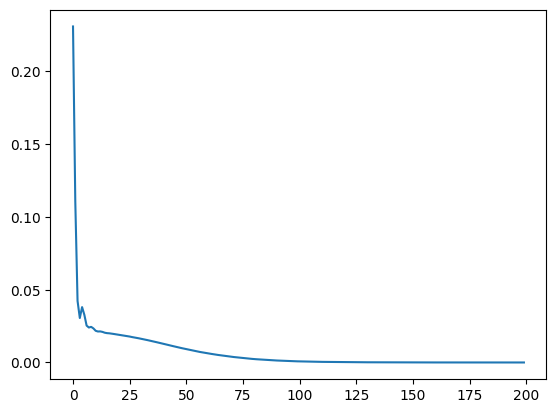

In [ ]:
plt.plot(History.history['loss'])
ConvLSTM_model.evaluate(X,Y)

In [ ]:
# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape((1, 1, 1, 600, 1))
Y_ = ConvLSTM_model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)



1/1 [==============================] - 0s 297ms/step


<ipython-input-203-34dd4c117c14>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[1000:].append(df_future).set_index('Date')


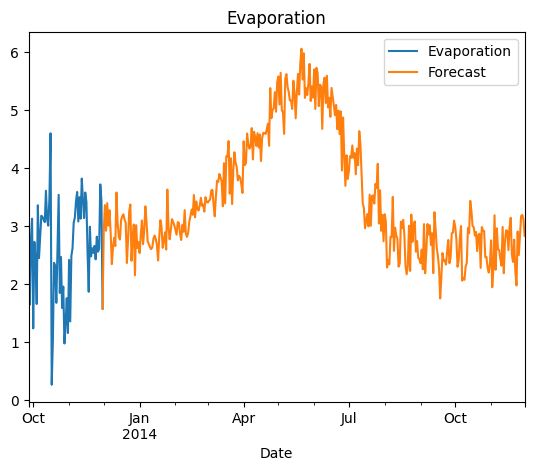

<ipython-input-203-34dd4c117c14>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


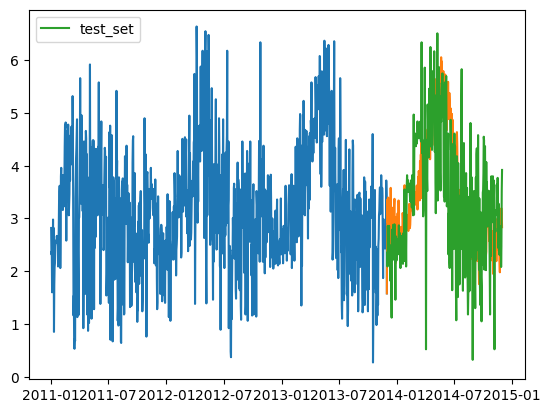

<ipython-input-203-34dd4c117c14>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past[2000:].append(df_future).set_index('Date')


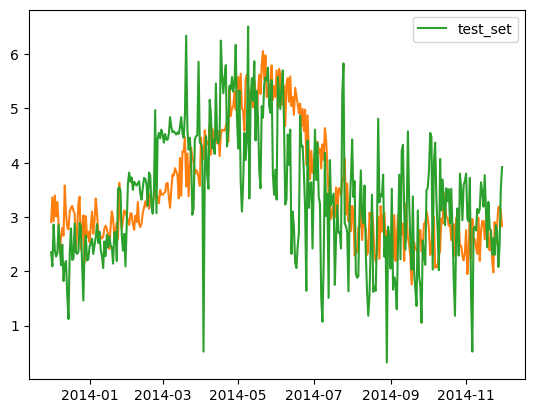

In [ ]:
showResult()

In [ ]:
print('MAE',mae(test_df,Y_))
print('MAPE',mape(test_df,Y_))
print('RMSE',rmse(test_df,Y_))

MAE 0.7879661788287229
MAPE 31.851403703421166
RMSE 1.0040718328268194


# Arima